# 3 — Sampling the Imaginary

## 3.1 Vampire Blood-Test Problem

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [3]:
Pr_positive_vampire = .95
Pr_positive_mortal = .01
Pr_vampire = .001

# Pr_positive is just the average positive value
Pr_positive = (Pr_positive_vampire * Pr_vampire) + (Pr_positive_mortal * (1 - Pr_vampire))

Pr_vampire_positive = round((Pr_positive_vampire * Pr_vampire) / Pr_positive, 3)
print(Pr_vampire_positive)

0.087


In [4]:
# 3.1 Sampling from a grid-approximate posterior
p_grid = np.linspace(0, 1, 1000)
prob_p = np.ones(1000)
prob_data = stats.binom.pmf(k=6, n=9, p=p_grid)
posterior = prob_data * prob_p # "Remember, the posterior here means the probability of p conditional on the data."
posterior /= posterior.sum() # Normalize the posterior

"Now we wish to draw 10,000 samples from this posterior. Imagine the posterior is a bucket
full of parameter values, numbers such as 0.1, 0.7, 0.5, 1, etc. Within the bucket, each value
exists in proportion to its posterior probability, such that values near the peak are much more
common than those in the tails. We’re going to scoop out 10,000 values from the bucket.
Provided the bucket is well mixed, the resulting samples will have the same proportions as
the exact posterior density. Therefore the individual values of p will appear in our samples
in proportion to the posterior plausibility of each value." (p. 52)

In [5]:
# "The workhorse here is [np.random.choice], which randomly pulls values from a vector [numpy array]. The vector in
# this case is p_grid, the grid of parameter values. The probability of each value is given by
# posterior, which you computed just above."
samples = np.random.choice(p_grid, size=10000, p=posterior, replace=True)

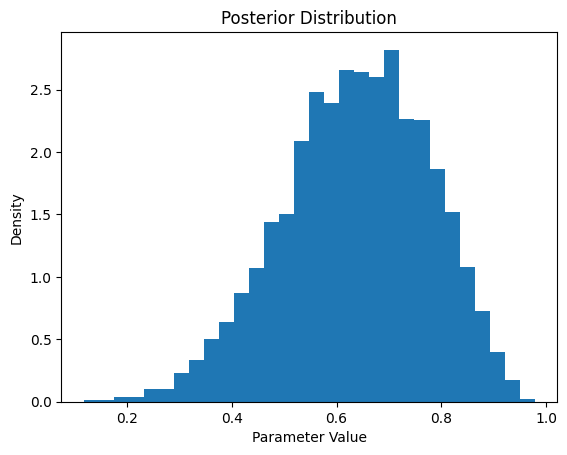

In [6]:
# Code 3.4
plt.hist(samples, bins=30, density=True)
plt.xlabel('Parameter Value')
plt.ylabel('Density')
plt.title('Posterior Distribution')
plt.show()

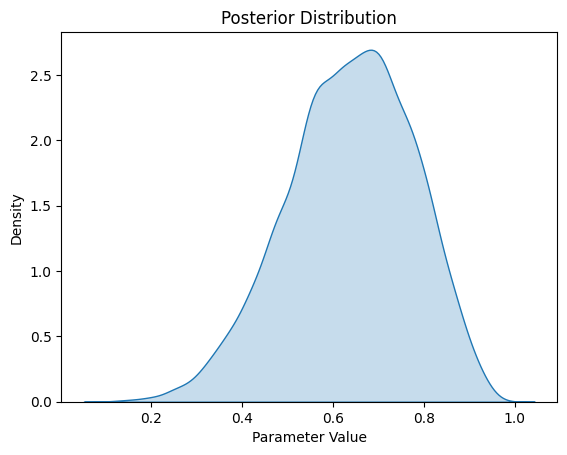

In [7]:
# Code 3.5
sns.kdeplot(samples, fill=True)
plt.xlabel('Parameter Value')
plt.ylabel('Density')
plt.title('Posterior Distribution')
plt.show()

## 3.2 Sampling to Summarize

In [8]:
# Code 3.6
np.sum(posterior[p_grid < 0.5])

0.1718745890202287

In [9]:
# Code 3.7
np.sum((samples < 0.5) / len(samples))

0.1687

In [10]:
# Code 3.8 — How much of the posterior probability lies between 0.5 and 0.75?
np.sum(((samples > 0.5) & (samples < 0.75)) / len(samples))

0.6063000000000002

#### Overthinking `sum`
"In the [Python] code examples using [NumPy], I used the np.sum function to effectively count up how many samples fulfill a logical criterion. Why does this work? It works because [NumPy] internally converts a logical expression, like samples < 0.5, to a [NumPy] array of [boolean] values ([True] or [False]), one for each element of samples, indicating whether or not each element matches the criterion. When you apply np.sum to this [boolean] array, [NumPy] treats [True] as 1 and [False] as 0, effectively summing the number of [True] values. This gives us the count of elements in samples that satisfy the logical criterion."

In [11]:
# Code 3.9 — Ask where the 80th percentile lies
np.quantile(samples, 0.8)

0.7617617617617618

In [12]:
# Code 3.10 — Both the 10th and 90th percentiles (percentile intervals)
np.quantile(samples, [0.1, 0.9])

array([0.45145145, 0.81281281])

In [13]:
# Code 3.11 — Demonstrating the limitations of percentile intervals
## "This posterior is consistent with observing three waters in three tosses and a
## uniform (flat) prior. It is highly skewed, having its maximum value at the boundary, p = 1."
p_grid = np.linspace(0, 1, 1000)
prior = np.ones(1000) / 1000 # Uniform prior
likelihood = stats.binom.pmf(3, 3, p_grid)

## Posterior
posterior = likelihood * prior
posterior /= posterior.sum()

## Sample from the posterior distribution
samples = np.random.choice(p_grid, size=10000, p=posterior, replace=True)
samples

array([0.83483483, 0.84384384, 0.86786787, ..., 0.8958959 , 0.91891892,
       0.90590591])

In [14]:
# Code 3.12 — Get the Probability Interval (a type of Credible Interval)
prob = 0.5
lower_bound = np.percentile(samples, (1 - prob) / 2 * 100)
upper_bound = np.percentile(samples, (1 + prob) / 2 * 100)

pi = (lower_bound, upper_bound)
pi

(0.7097097097097097, 0.9301801801801802)

"This interval assigns 25% of the probability mass above and below the interval. So it provides the central 50% probability. But in this example, it ends up excluding the most probable parameter values, near p = 1. So in terms of describing the shape of the posterior distribution—which is really all these intervals are asked to do—the percentile interval can be misleading."

In [15]:
# Code 3.13
hpdi = az.hdi(samples, hdi_prob=0.5)
print("50% HPDI: ", hpdi)

50% HPDI:  [0.84184184 0.996997  ]


"This interval captures the parameters with highest posterior probability, as well as being noticeably narrower: 0.16 in width rather than 0.23 for the percentile interval. So the HPDI has some advantages over the PI. But in most cases, these two types of interval are very similar. They only look so different in this case because the posterior distribution is highly skewed. If we instead used samples from the posterior distribution for six waters in nine tosses, these intervals would be nearly identical. Try it for yourself, using different probability masses, such as prob=0.8 and prob=0.95. When the posterior is bell shaped, it hardly matters which type of interval you use. Remember, we’re not launching rockets or calibrating atom smashers, so fetishizing precision to the 5th decimal place will not improve your science."

In [ ]:
hpdi_8 = az.hdi(samples, hdi_prob=0.8)
hpdi_95 = az.hdi(samples, hdi_prob=0.95)
print(f"prob=0.8: {hpdi_8}")
print(f"prob=0.95: {hpdi_95}")

prob=0.8: [0.67167167 1.        ]
prob=0.95: [0.46846847 1.        ]
